In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor  # Changed model
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

class EnergyPredictionModel:
    def __init__(self, file_path, x_values=5):
        self.file_path = file_path
        self.x_values = x_values
        self.data = None
        self.train_data = None
        self.test_data = None
        self.model = None
        self.FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'lag_1', 'lag_24', 'rolling_mean', 'rolling_std']
        self.TARGET = 'energy'

    def check_nan_and_replace_with_avg(self, data):
        data = data.copy()
        for i in range(len(data)):
            if np.isnan(data.iloc[i]):
                valid_values = []
                for j in range(1, self.x_values + 1):
                    if i - j >= 0 and not np.isnan(data.iloc[i - j]):
                        valid_values.append(data.iloc[i - j])
                    if len(valid_values) >= 1:
                        break
                if valid_values:
                    data.iloc[i] = np.mean(valid_values)
        return data

    def calculate_scaling_factor(self):
        # Calculate scaling factor based on historical energy data
        if self.train_data['energy'].isnull().all():
            return 1.0  # Default scaling factor if no data is available

        # Using the mean or standard deviation as a scaling factor
        mean_energy = self.train_data['energy'].mean()
        if mean_energy > 0:
            return mean_energy
        else:
            return 1.0  # Fallback to 1.0 to avoid division by zero


    def calculate_trend_value(self, dt):
        # Filter the training data up to the specified datetime
        historical_data = self.train_data[self.train_data.index <= pd.to_datetime(dt)]

        # Ensure you have enough data points
        if len(historical_data) < 2:
            return 0.0  # Not enough data to calculate a trend

        # Prepare the data for linear regression
        X = np.arange(len(historical_data)).reshape(-1, 1)  # Time as a feature
        y = historical_data['energy'].values  # Historical energy values

        # Fit linear regression model
        model = LinearRegression()
        model.fit(X, y)

        # The slope of the line (the coefficient) represents the trend
        trend_value = model.coef_[0]

        # Calculate the scaling factor
        scaling_factor = self.calculate_scaling_factor()

        # Scale the trend value
        scaled_trend_value = trend_value * scaling_factor
        return scaled_trend_value


    def load_and_preprocess_data(self):
        self.data = pd.read_csv(self.file_path)
        # print(self.data.head())  # Add this line to check the initial data
        self.data['datetime'] = pd.to_datetime(self.data['datetime'])
        self.data = self.data.set_index('datetime')

        # Handle NaN values
        self.data['energy'] = self.check_nan_and_replace_with_avg(self.data['energy'])
        print("NaN values handled.")

    def create_features(self, df):
        df = df.copy()
        df['hour'] = df.index.hour
        df['dayofweek'] = df.index.dayofweek
        df['quarter'] = df.index.quarter
        df['month'] = df.index.month
        df['year'] = df.index.year
        df['dayofyear'] = df.index.dayofyear

        # Lag features
        df['lag_1'] = df['energy'].shift(1)
        df['lag_24'] = df['energy'].shift(24)

        # Rolling features
        df['rolling_mean'] = df['energy'].rolling(window=24).mean()
        df['rolling_std'] = df['energy'].rolling(window=24).std()

        # Cyclical features
        df['hour_sin'] = np.sin(df['hour'] * (2. * np.pi / 24))
        df['hour_cos'] = np.cos(df['hour'] * (2. * np.pi / 24))
        df['month_sin'] = np.sin(df['month'] * (2. * np.pi / 12))
        df['month_cos'] = np.cos(df['month'] * (2. * np.pi / 12))

        return df.dropna()  # Drop NaN values created by shifting

    def split_data(self, split_date='01-01-2015'):
        self.train_data = self.data.loc[self.data.index < split_date]
        self.test_data = self.data.loc[self.data.index >= split_date]

        # Create time-based features
        self.train_data = self.create_features(self.train_data)
        self.test_data = self.create_features(self.test_data)
        print("Data split into train and test sets.")

    def train_model(self):
        X_train = self.train_data[self.FEATURES]
        y_train = self.train_data[self.TARGET]

        self.model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
        self.model.fit(X_train, y_train)
        print("Model trained.")

    def predict_for_datetime(self, dt):
        # Calculate the trend value based on historical data up to the specified datetime
        self.trend_value = self.calculate_trend_value(dt)

        # Create an empty DataFrame for the specific datetime
        df = pd.DataFrame(index=[pd.to_datetime(dt)])

        # Create time-based features for the DataFrame
        df['hour'] = df.index.hour
        df['dayofweek'] = df.index.dayofweek
        df['quarter'] = df.index.quarter
        df['month'] = df.index.month
        df['year'] = df.index.year
        df['dayofyear'] = df.index.dayofyear

        # Lag features: use the last known values from the training data if available
        if not self.train_data.empty:
            df['lag_1'] = self.train_data['energy'].iloc[-1]  # Use the last known energy value
            df['lag_24'] = self.train_data['energy'].iloc[-24]  # Use the energy value from 24 hours ago

        # Rolling features: since it's a single point, these can't be calculated here
        df['rolling_mean'] = self.train_data['energy'].rolling(window=24).mean().iloc[-1]  # Last rolling mean
        df['rolling_std'] = self.train_data['energy'].rolling(window=24).std().iloc[-1]  # Last rolling std

        # Predict using the trained model
        prediction = self.model.predict(df[self.FEATURES])

        # Add the calculated and scaled trend value to the prediction
        final_prediction = prediction[0] + self.trend_value

        print(f"Predicted energy for {dt} with trend: {final_prediction}")
        return final_prediction

    def calculate_error_percentage(self, y_true, y_pred):
        error_percentage = np.abs(y_true - y_pred) / y_true * 100
        mean_error_percentage = np.mean(error_percentage)
        print(f"Mean Error Percentage: {mean_error_percentage:.2f}%")
        return mean_error_percentage

    def calculate_accuracy(self, y_true, y_pred):
        error_percentage = self.calculate_error_percentage(y_true, y_pred)
        accuracy = 100 - error_percentage
        print(f"Model Accuracy: {accuracy:.2f}%")
        return accuracy

    def calculate_mean(self, values):
        mean_value = np.mean(values)
        print(f"Mean: {mean_value:.2f}")
        return mean_value

    def calculate_std(self, values):
        std_value = np.std(values)
        print(f"Standard Deviation: {std_value:.2f}")
        return std_value


In [37]:
# Example usage of the EnergyPredictionModel class

# File path to the CSV file containing energy consumption data
file_path = './processed_train_data.csv'  # Replace with your actual file path

# Initialize the EnergyPredictionModel
energy_model = EnergyPredictionModel(file_path)

# Load and preprocess the data
energy_model.load_and_preprocess_data()

# Split the data into training and testing sets
energy_model.split_data(split_date='2015-01-01 01:00:00')

# Train the model
energy_model.train_model()



NaN values handled.
Data split into train and test sets.
Model trained.


In [38]:
# Make predictions on the test set
X_test = energy_model.test_data[energy_model.FEATURES]
y_test = energy_model.test_data[energy_model.TARGET]

# Generate predictions
y_pred = energy_model.model.predict(X_test)

# Predict energy for a specific datetime
dt = '2015-01-02 15:00:00'  # Example datetime
energy_model.predict_for_datetime(dt)

Predicted energy for 2015-01-02 15:00:00 with trend: 2350.6142478258844


2350.6142478258844

In [39]:
# Calculate mean and standard deviation of actual and predicted values
mean_actual = energy_model.calculate_mean(y_test)
std_actual = energy_model.calculate_std(y_test)
mean_predicted = energy_model.calculate_mean(y_pred)
std_predicted = energy_model.calculate_std(y_pred)

# Calculate and print error percentage and accuracy
energy_model.calculate_error_percentage(y_test, y_pred)
energy_model.calculate_accuracy(y_test, y_pred)

Mean: 1955.14
Standard Deviation: 327.08
Mean: 1952.12
Standard Deviation: 322.65
Mean Error Percentage: 1.61%
Mean Error Percentage: 1.61%
Model Accuracy: 98.39%


98.38937773616989

In [40]:
print(energy_model.trend_value)


12.898167949724373


In [41]:
# Predict energy for a specific datetime

dt = '2099-01-01 08:00:00'

energy_model.predict_for_datetime(dt)

Predicted energy for 2099-01-01 08:00:00 with trend: 2366.5874757887827


2366.5874757887827

In [42]:
# # Usage Example
# if __name__ == "__main__":

# Initialize the model
energy_model = EnergyPredictionModel(file_path='./processed_train_data.csv', x_values=5)

# Load and preprocess the data
energy_model.load_and_preprocess_data()

# Split data into train and test sets
energy_model.split_data(split_date='01-01-2015')

# Train the model
energy_model.train_model()



NaN values handled.
Data split into train and test sets.
Model trained.


In [43]:
# Predict energy for a specific datetime
energy_model.predict_for_datetime('2018-12-27 23:00:00')

Predicted energy for 2018-12-27 23:00:00 with trend: 2458.8178730718473


2458.8178730718473

In [44]:
# Get true and predicted values for the test set
y_test = energy_model.test_data[energy_model.TARGET]
X_test = energy_model.test_data[energy_model.FEATURES]
y_pred_test = energy_model.model.predict(X_test)

# Calculate the error percentage and model accuracy
energy_model.calculate_error_percentage(y_test, y_pred_test)
energy_model.calculate_accuracy(y_test, y_pred_test)

Mean Error Percentage: 1.61%
Mean Error Percentage: 1.61%
Model Accuracy: 98.39%


98.3891665474521

In [45]:
# Calculate mean and standard deviation for actual values
print(f"The mean of the actual values is: {energy_model.calculate_mean(y_test):.2f}")
print(f"The standard deviation of the actual values is: {energy_model.calculate_std(y_test):.2f}")

# Calculate mean and standard deviation for predicted values
print(f"The mean of the predicted values is: {energy_model.calculate_mean(y_pred_test):.2f}")
print(f"The standard deviation of the predicted values is: {energy_model.calculate_std(y_pred_test):.2f}")

Mean: 1955.15
The mean of the actual values is: 1955.15
Standard Deviation: 327.08
The standard deviation of the actual values is: 327.08
Mean: 1952.13
The mean of the predicted values is: 1952.13
Standard Deviation: 322.65
The standard deviation of the predicted values is: 322.65


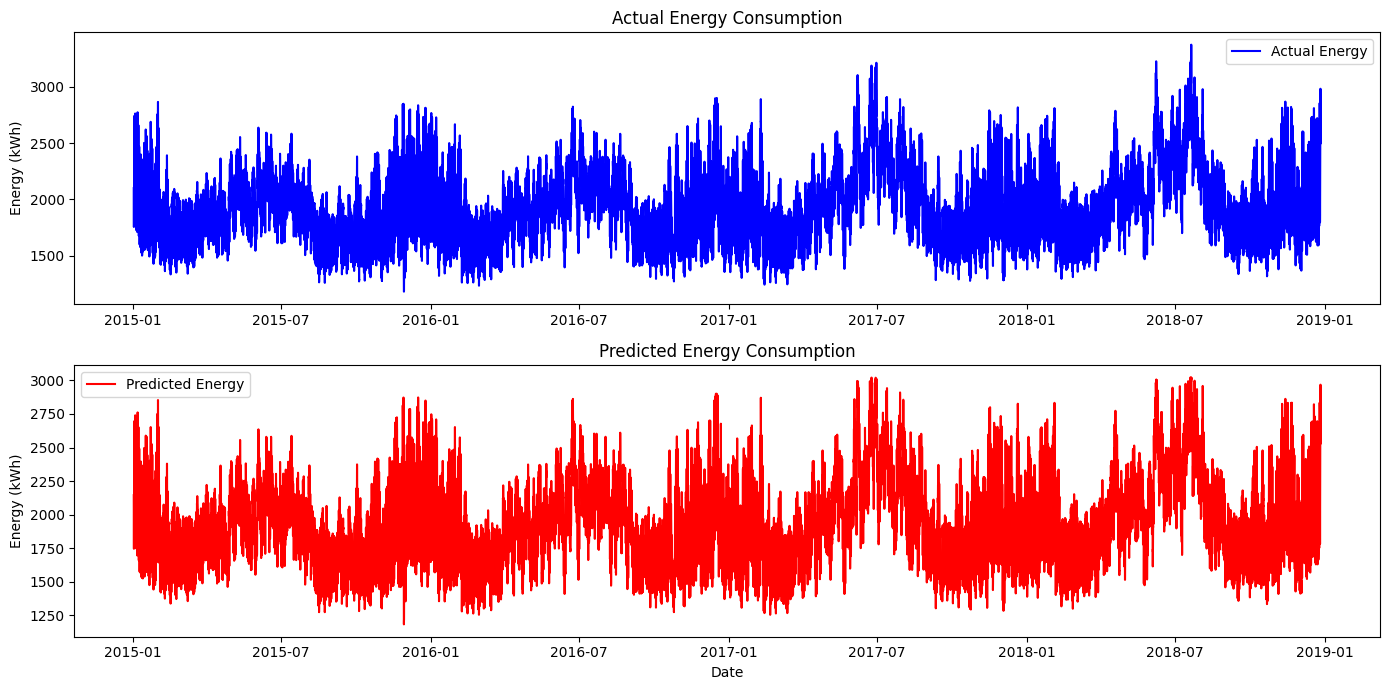

In [47]:
# plot a graph of values of test energy and predicted energy seperately as subplots
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(y_test.index, y_test.values, label='Actual Energy', color='blue')
plt.title('Actual Energy Consumption')
plt.ylabel('Energy (kWh)')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(y_test.index, y_pred_test, label='Predicted Energy', color='red')
plt.title('Predicted Energy Consumption')
plt.xlabel('Date')
plt.ylabel('Energy (kWh)')
plt.legend()
plt.tight_layout()
plt.show()

